In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
from ses_network_3_0 import SESNetwork
#from extraction_works.ses_network_2_0_copy import SESNetwork
from utils import make_input, LatentSpace, get_sample_from_num_swaps, get_cos_sim_np, get_cos_sim_torch, test_network, get_ordered_weights

In [4]:
network_parameters = {}

network_parameters["hebbian_filter"] = False

network_parameters["duration_phase_A"] = 1000
network_parameters["duration_phase_B"] = 1500

network_parameters["sleep_duration_A"] = 10
network_parameters["sleep_duration_B"] = 10
network_parameters["reset_dayly"] = True

network_parameters["regions"] = ["sen", "mtl_sparse", "mtl_dense", "mtl", "ctx"]

network_parameters["mtl_pattern_complete_iterations"] = 10
network_parameters["mtl_dense_pattern_complete_iterations"] = 10
network_parameters["mtl_sparse_pattern_complete_iterations"] = 10
network_parameters["ctx_pattern_complete_iterations"] = 10
network_parameters["mtl_generate_pattern_complete_iterations"] = 10

network_parameters["max_semantic_charge"] = 2

network_parameters["sen_num_subregions"] = 1
network_parameters["sen_size_subregions"] = torch.tensor([100])
network_parameters["sen_sparsity"] = torch.tensor([0.2])
network_parameters["sen_sparsity_sleep"] = torch.tensor([0.2])

network_parameters["ctx_num_subregions"] = 2
network_parameters["ctx_size_subregions"] =  torch.tensor([100, 250])
network_parameters["ctx_sparsity"] = torch.tensor([0.2, 1/25])
network_parameters["ctx_sparsity_sleep"] = torch.tensor([0.1, 1/25])

network_parameters["mtl_num_subregions"] = 2
network_parameters["mtl_size_subregions"] =  torch.tensor([100, 100])
network_parameters["mtl_sparsity"] = torch.tensor([0.2, 0.1])
network_parameters["mtl_sparsity_sleep"] = torch.tensor([0.1, 0.05])

network_parameters["mtl_dense_num_subregions"] = 1
network_parameters["mtl_dense_size_subregions"] = torch.tensor([100])
network_parameters["mtl_dense_sparsity"] = torch.tensor([0.2])
network_parameters["mtl_dense_sparsity_sleep"] = torch.tensor([0.1])

network_parameters["mtl_sparse_num_subregions"] = 1
network_parameters["mtl_sparse_size_subregions"] = torch.tensor([100])
network_parameters["mtl_sparse_sparsity"] = torch.tensor([0.1])
network_parameters["mtl_sparse_sparsity_sleep"] = torch.tensor([0.05])

network_parameters["mtl_dense_sen_projection"] = False
network_parameters["mtl_dense_sen_sparsity"] = 0.5

network_parameters["ctx_mtl_quick_lmbda"] = 1e-2
network_parameters["max_pre_ctx_mtl_quick"] = np.inf
network_parameters["max_post_ctx_mtl_quick"] = 1

network_parameters["ctx_mtl_sparsity"] = 0.5
network_parameters["ctx_mtl_mean"] = 0.03
network_parameters["ctx_mtl_std"] = 0.001
network_parameters["ctx_mtl_lmbda"] = 5e-4
network_parameters["ctx_mtl_size"] = 2
network_parameters["max_pre_ctx_mtl"] = np.inf
network_parameters["max_post_ctx_mtl"] = 1

network_parameters["ctx_mtl_sparse_mean"] = 0.07
network_parameters["ctx_mtl_sparse_std"] = 0.001
network_parameters["ctx_mtl_sparse_lmbda"] = 5e-4
network_parameters["max_pre_ctx_mtl_sparse"] = np.inf
network_parameters["max_post_ctx_mtl_sparse"] = 1

network_parameters["ctx_mtl_dense_sparsity"] = 0.5
network_parameters["ctx_mtl_dense_g"] = 0.01

network_parameters["mtl_mtl_lmbda"] = 5e-3
network_parameters["max_pre_mtl_mtl"] = 1
network_parameters["max_post_mtl_mtl"] = np.inf

network_parameters["mtl_dense_mtl_dense_lmbda"] = 5e-3
network_parameters["max_pre_mtl_dense_mtl_dense"] = 1
network_parameters["max_post_mtl_dense_mtl_dense"] = np.inf

network_parameters["mtl_sparse_mtl_sparse_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_mtl_sparse"] = 1
network_parameters["max_post_mtl_sparse_mtl_sparse"] = np.inf

network_parameters["ctx_ctx_sparsity"] = 0.05
network_parameters["ctx_ctx_g"] = 1e-4
network_parameters["ctx_ctx_lmbda"] = 5e-4
network_parameters["max_pre_ctx_ctx"] = 1
network_parameters["max_post_ctx_ctx"] = np.inf

network_parameters["mtl_sparse_ctx_mean"] = 0.03
network_parameters["mtl_sparse_ctx_std"] = 0.001
network_parameters["mtl_sparse_ctx_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_ctx"] = np.inf
network_parameters["max_post_mtl_sparse_ctx"] = 1


recording_parameters = {}
recording_parameters["regions"] = ["sen", "mtl_hat", "mtl_dense", "mtl_sparse", "mtl_sparse_hat", "mtl", "ctx", "ctx_hat"]
recording_parameters["rate_activity"] = 1
#recording_parameters["connections"] = ["mtl_mtl", "ctx_mtl", "ctx_ctx", "ctx_mtl_quick", "mtl_sparse_ctx"]
recording_parameters["connections"] = ["ctx_mtl"]
recording_parameters["rate_connectivity"] = 1

In [5]:
input_params = {}
input_params["num_days"] = 1000
input_params["day_length"] = 40
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 8

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]

'''
latent_specs["num"] = 5
latent_specs["total_sizes"] = [20, 20, 20, 20, 20]
latent_specs["act_sizes"] = [10, 10, 10, 10, 10]
latent_specs["dims"] = [2, 2, 2, 2, 2]
'''

'\nlatent_specs["num"] = 5\nlatent_specs["total_sizes"] = [20, 20, 20, 20, 20]\nlatent_specs["act_sizes"] = [10, 10, 10, 10, 10]\nlatent_specs["dims"] = [2, 2, 2, 2, 2]\n'

In [6]:
def test_network(net, input_params, print_rate=1):
  input, input_episodes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      net.sleep()
  return input, input_episodes, input_latents, net

In [7]:
#latent_specs["prob_list"] = [0.05 if i==j else 0.05/9 for i in range(10) for j in range(10)]
#latent_specs["prob_list"] = [1/100 for i in range(10) for j in range(10)]
#latent_specs["prob_list"] = [1/32 for i in range(32)]

latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
#latent_specs["prob_list"] = [0.1 if i==j else 0.1/4 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
network = SESNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
#torch.save(network, "network.pt")

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


Text(0.5, 0, 'Time')

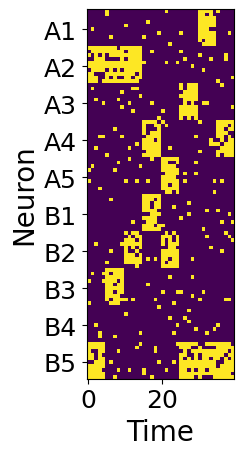

In [8]:
plt.imshow(torch.stack(network.activity_recordings["mtl"], dim=0)[network.awake_indices][:input_params["day_length"], :100].reshape(-1, 100).T)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)

Text(0.5, 0, 'Time')

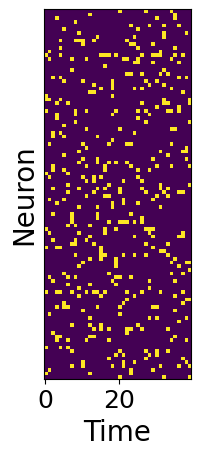

In [9]:
plt.imshow(torch.stack(network.activity_recordings["mtl"], dim=0)[network.awake_indices][:input_params["day_length"], 100:].reshape(-1, 100).T)

plt.yticks([])
plt.xticks([0, 20], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)

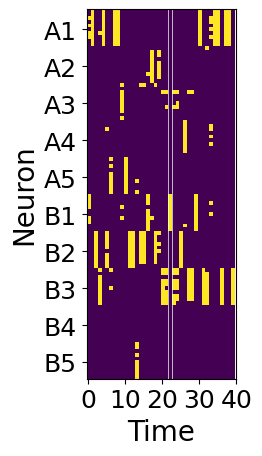

In [10]:
plt.imshow(torch.stack(network.activity_recordings["mtl"], dim=0)[network.sleep_indices_A][-input_params["day_length"]:, :100].reshape(-1, 100).T)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 10, 20, 30, 40], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.axvline(21.5, lw=0.5, color='white')
plt.axvline(22.5, lw=0.5, color='white')

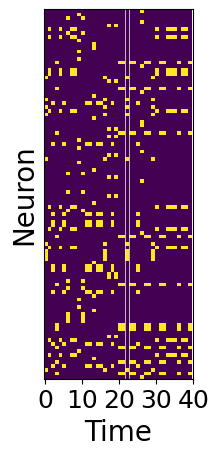

In [11]:
plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_A][-input_params["day_length"]:, :100].reshape(-1, 100).T)
plt.yticks([])
plt.xticks([0, 10, 20, 30, 40], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.axvline(21.5, lw=0.5, color='white')
plt.axvline(22.5, lw=0.5, color='white')

In [12]:
rf_ctx_mtl = torch.stack(network.connectivity_recordings["ctx_mtl"], dim=0)

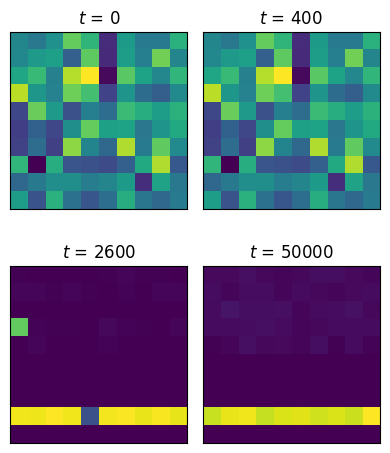

In [14]:
neuron = 12
fig, axs = plt.subplots(2, 2, figsize=(4, 5))  # 1 row, 3 columns

# Example plots
axs[0, 0].imshow(rf_ctx_mtl[0, neuron, :100].reshape(-1, 10))
axs[0, 0].set_title(r'$t$ = 0')

axs[0, 1].imshow(rf_ctx_mtl[400, neuron, :100].reshape(-1, 10))
axs[0, 1].set_title(r'$t$ = 400')

axs[1, 0].imshow(rf_ctx_mtl[2600, neuron, :100].reshape(-1, 10))
axs[1, 0].set_title(r'$t$ = 2600')

axs[1, 1].imshow(rf_ctx_mtl[50000, neuron, :100].reshape(-1, 10))
axs[1, 1].set_title(r'$t$ = 50000')

for i, axs in enumerate(axs.flat):
    axs.set_xticks([])
    axs.set_yticks([])
plt.tight_layout()
plt.show()

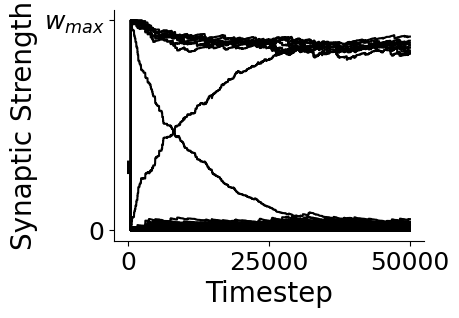

In [15]:
fig = plt.figure(figsize=(4, 3))
# Example plots
for w in rf_ctx_mtl[:, neuron, :100].transpose(0, 1):
    plt.plot(w, color='black')
plt.xlabel("Timestep", fontsize=20)
plt.ylabel("Synaptic Strength", fontsize=20)
plt.xticks([0, 25000, 50000], fontsize=18)
plt.yticks([0, 0.1], [0, r"$w_{max}$"], fontsize=18)
sns.despine()

In [16]:
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)

In [17]:
# Flatten time
days, day_length, num_latents = X_latent_AB.shape
_, num_neurons = X_ctx.shape

latents_flat = X_latent_AB.reshape(-1, num_latents).float()    # shape: (days * day_length, num_latents)
neurons_ctx_flat = X_ctx.reshape(-1, num_neurons).float()    # shape: (days * day_length, num_neurons)

# Normalize (zero mean, unit variance)
latents_norm = (latents_flat - latents_flat.mean(dim=0)) / latents_flat.std(dim=0)
neurons_ctx_norm = (neurons_ctx_flat - neurons_ctx_flat.mean(dim=0)) / neurons_ctx_flat.std(dim=0)


# Compute correlation (selectivity): (num_neurons, num_latents)
selectivity_ctx = neurons_ctx_norm.T @ latents_norm / latents_norm.shape[0]

In [18]:
threshold = 0.9
num_neurons, num_latents = selectivity_ctx.shape

# Identify the latent with the highest selectivity per neuron
max_selectivity, max_latent_idx = selectivity_ctx.max(dim=1)

# Assign neurons to latents if selectivity >= threshold, else assign -1 (non-selective)
assigned_latents = torch.where(max_selectivity >= threshold, max_latent_idx, -1)

# Generate reordered indices
ordered_indices = []

# Iterate over each latent to collect selective neurons
for latent in range(num_latents):
    latent_neurons = (assigned_latents == latent).nonzero(as_tuple=True)[0]
    ordered_indices.append(latent_neurons)

# Add non-selective neurons at the end
non_selective_neurons = (assigned_latents == -1).nonzero(as_tuple=True)[0]
ordered_indices.append(non_selective_neurons)

# Concatenate indices into a single ordering
ordered_indices = torch.cat(ordered_indices)


([], [])

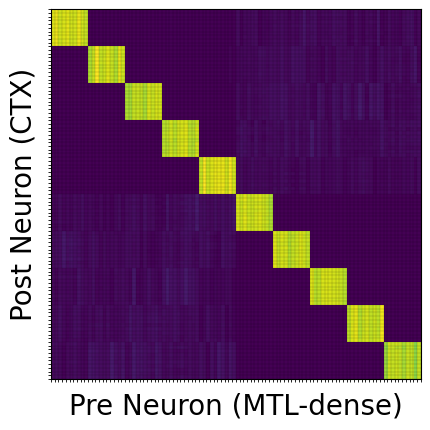

In [19]:
plt.imshow(network.ctx_mtl[ordered_indices[:100], :100])
plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (MTL-dense)", fontsize=20)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])

Text(0.5, 0, 'Pre Neuron (CTX)')

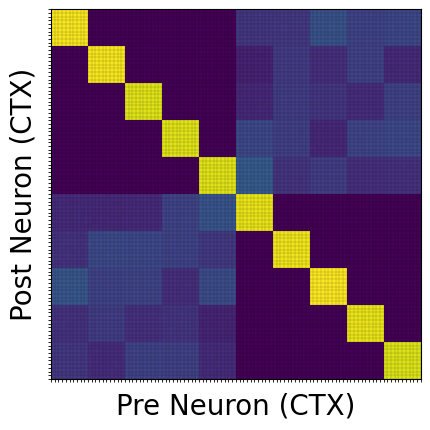

In [20]:
plt.imshow(network.ctx_ctx[ordered_indices[:100]][:, ordered_indices[:100]])
plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])

plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (CTX)", fontsize=20)

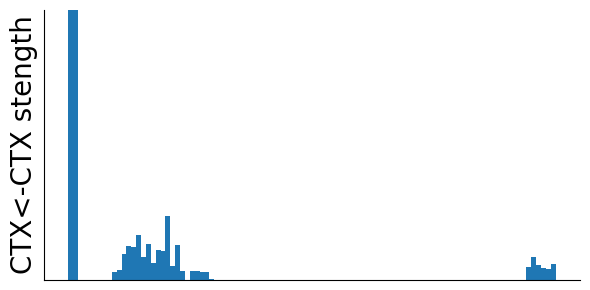

In [21]:
fig = plt.figure(figsize=(6, 3))
plt.hist(network.ctx_ctx.flatten(), bins=100)
plt.xticks([])
plt.yticks([])
plt.ylim([0, 3000])
plt.ylabel("CTX<-CTX stength", fontsize=20)
plt.tight_layout()
sns.despine()